In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/total_data_set.csv', thousands=',')

df['거래량'] = df.거래량.str.replace('K', '').astype('float32')
df['변동 %']=df.거래량.replace('%', '').astype('float32')

df

,날짜,종가,오픈,거래량,변동 %,실업자,실업률(%),청년실업자,청년실업률(%),빈도(부정),빈도(긍정),코스피지수변화,순매수비율
0,2017-05-23,3206000,3104000,21.580000,21.580000,99.5,3.6,40.8,9.2,16.90149,14.58574,0.0033,0.008202
1,2017-05-24,4175000,3206000,34.680000,34.680000,99.5,3.6,40.8,9.2,16.92568,15.11493,0.0024,0.008202
2,2017-05-25,4199000,4175000,35.910000,35.910000,99.5,3.6,40.8,9.2,16.57495,16.02447,0.0110,0.008202
3,2017-05-26,3227000,4199000,36.650002,36.650002,99.5,3.6,40.8,9.2,14.21660,12.58475,0.0053,0.008202
4,2017-05-27,3152000,3227000,33.750000,33.750000,99.5,3.6,40.8,9.2,10.08647,8.97965,0.0000,0.008202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,2021-07-02,39417000,39335000,0.520000,0.520000,92.0,3.2,30.8,7.2,16.68379,15.77641,-0.0001,0.002991
1502,2021-07-03,40335000,39413000,0.190000,0.190000,92.0,3.2,30.8,7.2,13.23093,10.73259,0.0000,0.002991
1503,2021-07-04,40914000,41183000,0.550000,0.550000,92.0,3.2,30.8,7.2,11.24750,10.78220,0.0000,0.002991
1504,2021-07-05,39484000,40914000,0.700000,0.700000,92.0,3.2,30.8,7.2,15.66184,17.03323,0.0035,0.002991


In [34]:
prediction_days = 121
split = len(df)-prediction_days
all_data = df.drop('날짜', axis=1)

scaler transformation

In [35]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input:
        data: dataframe with dates and price data
    output:
        X_train, y_train: data from 2013/1/1-2018/12/31
        X_test : data from 2019-
        sc :     insantiated MinMaxScaler object fit to the training data
    """
    # create training and test set

    ts_train = all_data[:split].iloc[:,0:1].values
    ts_test = all_data[split:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))

    inputs = pd.concat((all_data['종가'][:split], all_data['종가'][split:]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train , X_test, sc

In [36]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)
X_train.shape[0], X_train.shape[1]

(1379, 5)

In [37]:
# Convert the 3D shape of X_train to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1379 samples in the training data
There are 119 samples in the test data


In [38]:
X_train_see



,0,1,2,3,4
0,0.015711,0.031042,0.031422,0.016043,0.014856
1,0.031042,0.031422,0.016043,0.014856,0.014809
2,0.031422,0.016043,0.014856,0.014809,0.015711
3,0.016043,0.014856,0.014809,0.015711,0.014730
4,0.014856,0.014809,0.015711,0.014730,0.013005
...,...,...,...,...,...
1374,0.818780,0.812831,0.809999,0.784384,0.856609
1375,0.812831,0.809999,0.784384,0.856609,0.850407
1376,0.809999,0.784384,0.856609,0.850407,0.880120
1377,0.784384,0.856609,0.850407,0.880120,0.856546


In [39]:
y_train_see




,0,1
0,0.014809,0.015711
1,0.015711,0.014730
2,0.014730,0.013005
3,0.013005,0.014698
4,0.014698,0.015125
...,...,...
1374,0.850407,0.880120
1375,0.880120,0.856546
1376,0.856546,0.858998
1377,0.858998,0.852353


LSTM



In [51]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           input_shape = (X_train.shape[1],1),
                           activation = 'relu'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7,
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')

    # Fitting to the training set
    my_LSTM_model.fit(X_train, y_train, epochs = 200, batch_size = 50, verbose = 0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [52]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['actual', 'prediction'])
    actual_pred['actual'] = df.loc[split:,'종가'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['actual']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

/Users/juhyemin/Projects/Pycharm/pythonProject/btcPrediction/venv2/new/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(17983143000000.0, <AxesSubplot:>)

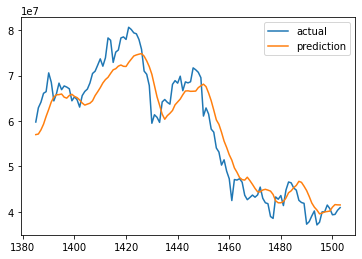

In [53]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)



In [54]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=all_data.loc[split:,'종가'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [56]:
confirm_result(y_test, y_pred)

,Results
MAE,3573971.02521
RMSE,4240653.78537
RMSLE,0.07251
R2,0.90165


GRU

In [57]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD

    # The GRU architecture
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50,
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7,
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')


    # Fitting to the trainig set
    my_GRU_model.fit(X_train, y_train, epochs = 200, batch_size = 50, verbose = 0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction


/Users/juhyemin/Projects/Pycharm/pythonProject/btcPrediction/venv2/new/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(10833778000000.0, <AxesSubplot:>)

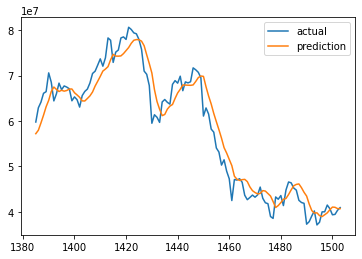

In [58]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [59]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=all_data.loc[split:,'종가'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [60]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,2661253.54622
RMSE,3291470.59760
RMSLE,0.05756
R2,0.94075
